# Imports and preapre tests

Test images extracted from video files as

```
ffmpeg -i project_video.mp4  project_video/%04d.jpg
ffmpeg -i challenge_video.mp4  -r 1/1 challenge_video/%04d.jpg
ffmpeg -i harder_challenge_video.mp4 harder_challenge_video/%04d.jpg
```

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from ipywidgets import interactive
import glob
import os
import pickle
import hashlib
import time

%matplotlib inline

In [2]:
test_images = ['test_images/straight_lines1.jpg', 'test_images/test1.jpg', 
               'challenge_video/0017.jpg', 'harder_challenge_video/1190.jpg']

# Camera calibration

In [3]:
def calibrate_camera(images, nx, ny):
    arghash = hashlib.md5(repr((images, nx, ny)).encode('utf-8')).hexdigest()
    calibration_pickle = 'calibration.p'
    if os.path.exists(calibration_pickle):
        p = pickle.load(open(calibration_pickle, 'rb'))
        mtx, dist = (p['mtx'], p['dist']) if 'hash' in p and arghash == p['hash'] else (None, None)
    if mtx is None:
        pattern = np.array([(x,y,0)  for y in range(ny) for x in range(nx)], dtype='float32')
        object_points, imgage_points = [], []
        for image in images:
            gray = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
            if ret:
                object_points.append(pattern)
                imgage_points.append(corners.reshape(nx * ny, 2))
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, imgage_points, gray.shape[::-1], None, None)
        pickle.dump({'mtx': mtx, 'dist': dist, 'hash': arghash}, open(calibration_pickle, 'wb'))
    return lambda image: cv2.undistort(image, mtx, dist, None, mtx)

undistort = (calibrate_camera(glob.glob('camera_cal/*.jpg'), 9, 6))

Calibration results

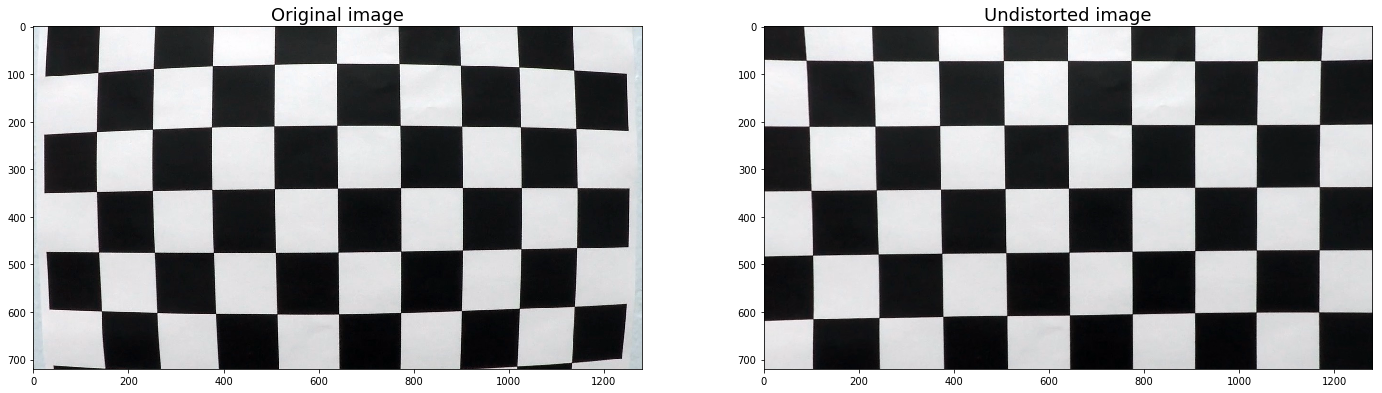

In [4]:
## Display both distorted and undistorted images
image = cv2.imread('camera_cal/calibration1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original image', fontsize=18)
ax2.imshow(undistort(image))
ax2.set_title('Undistorted image', fontsize=18)

dirname = 'output_images/calibration'
if not os.path.exists(dirname): os.mkdir(dirname)

## Save undistorted calibration images
for name in glob.glob('camera_cal/*.jpg'):
    save_to = os.path.join(dirname, os.path.basename(name))
    cv2.imwrite(save_to, undistort(cv2.imread(name)))

Undistorted test images

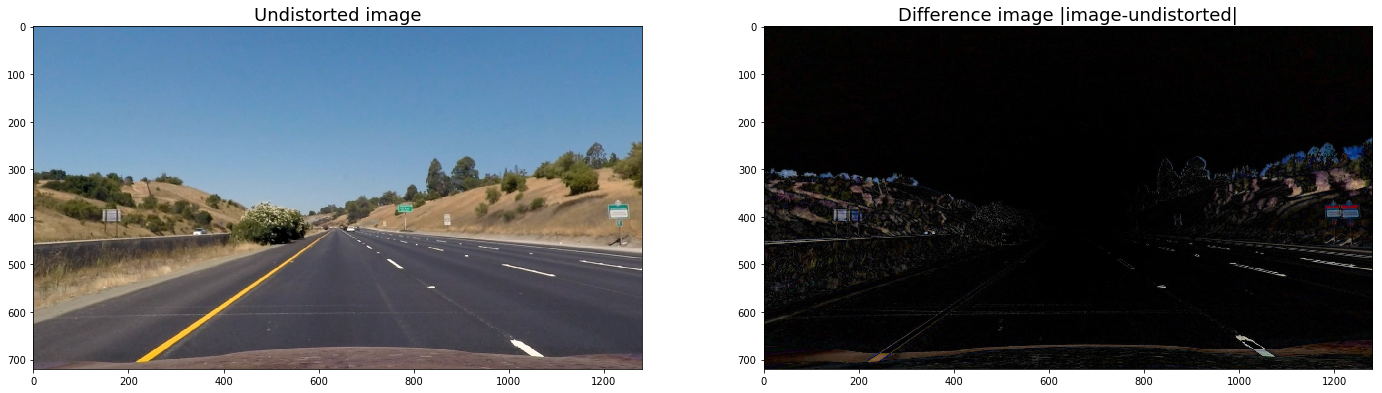

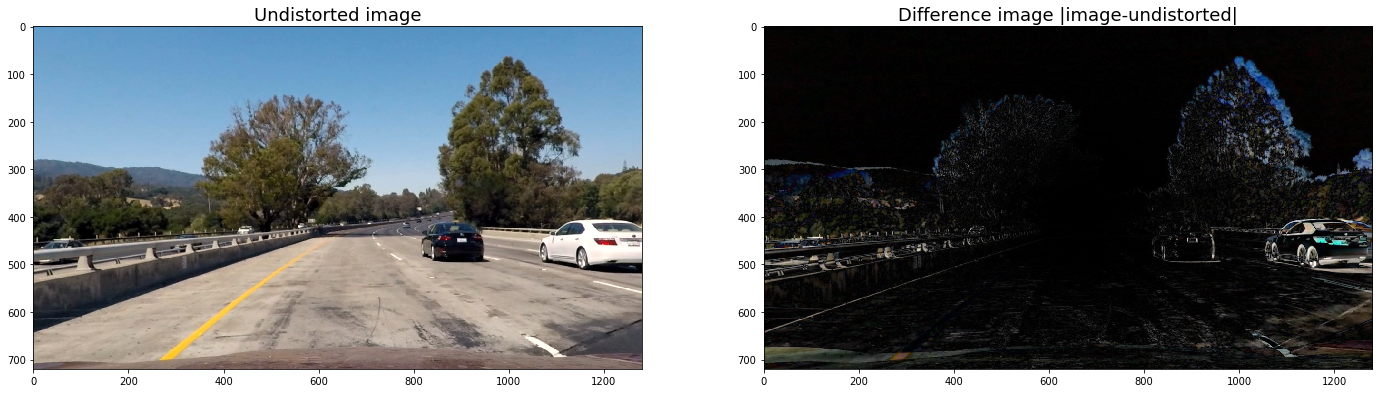

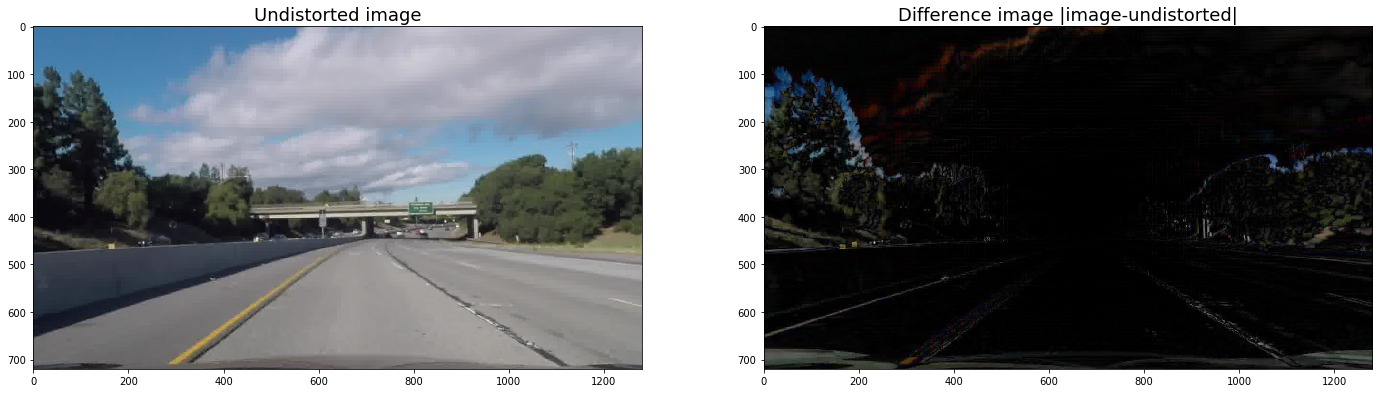

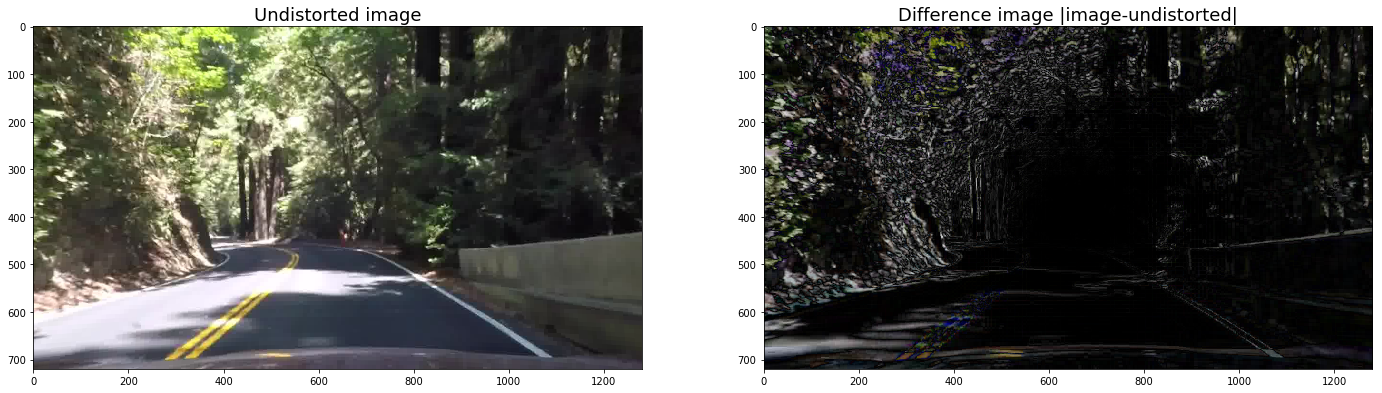

In [5]:
## Save undistorted calibration images
dirname = 'output_images/undistorted'
if not os.path.exists(dirname): os.mkdir(dirname)

## Save undistorted calibration images
for name in glob.glob('test_images/*.jpg'):
    save_to = os.path.join(dirname, os.path.basename(name))
    cv2.imwrite(save_to, undistort(cv2.imread(name)))
    
## Display undistorted test image and difference with the original one
for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    undistorted = undistort(image)
    diff = cv2.absdiff(image, undistort(image))
    ax1.imshow(undistorted)
    ax1.set_title('Undistorted image', fontsize=18)
    ax2.imshow(diff)
    ax2.set_title('Difference image |image-undistorted|', fontsize=18)
    
    save_to = os.path.join(dirname, 'img_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))
    save_to = os.path.join(dirname, 'diff_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(diff, cv2.COLOR_RGB2BGR))


## Perspective transform

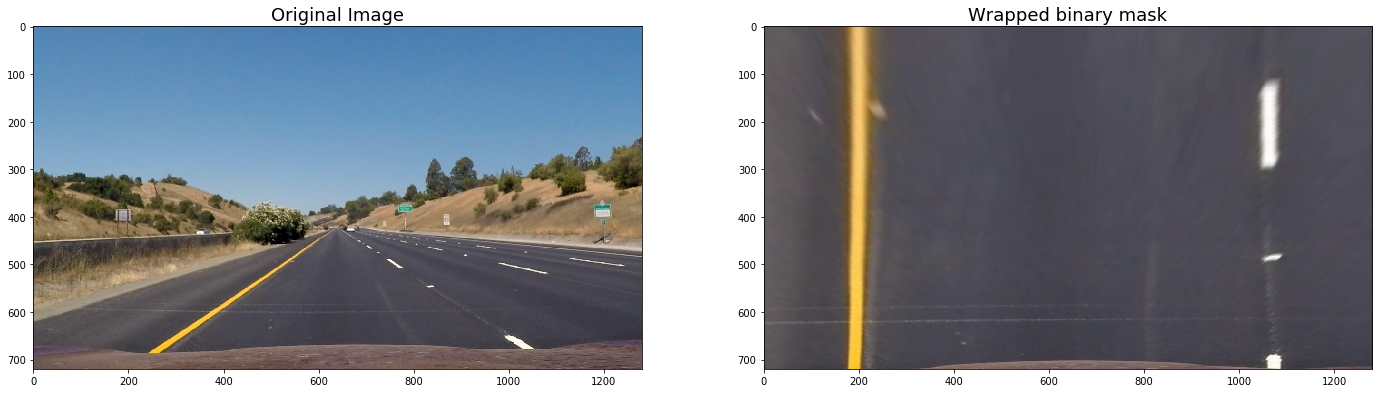

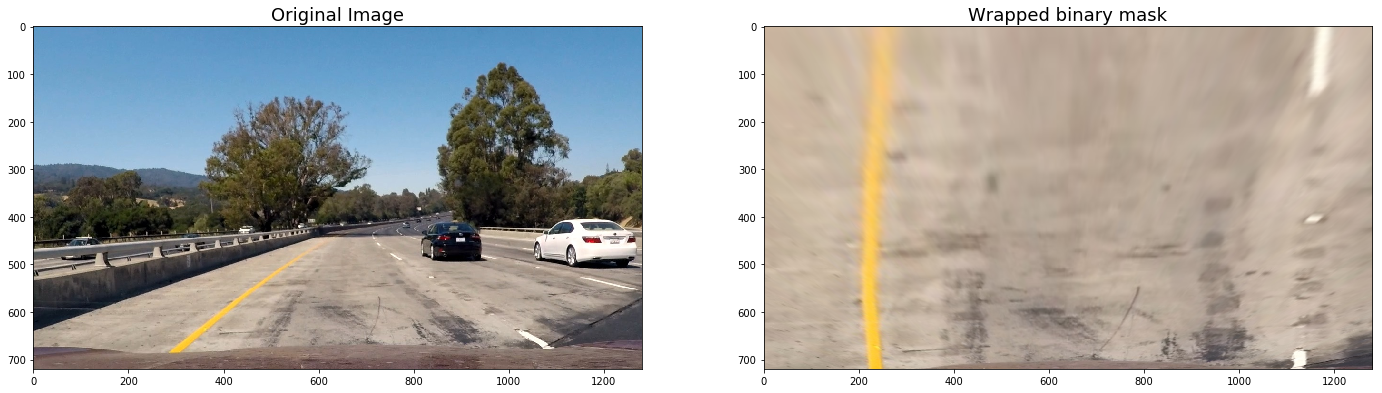

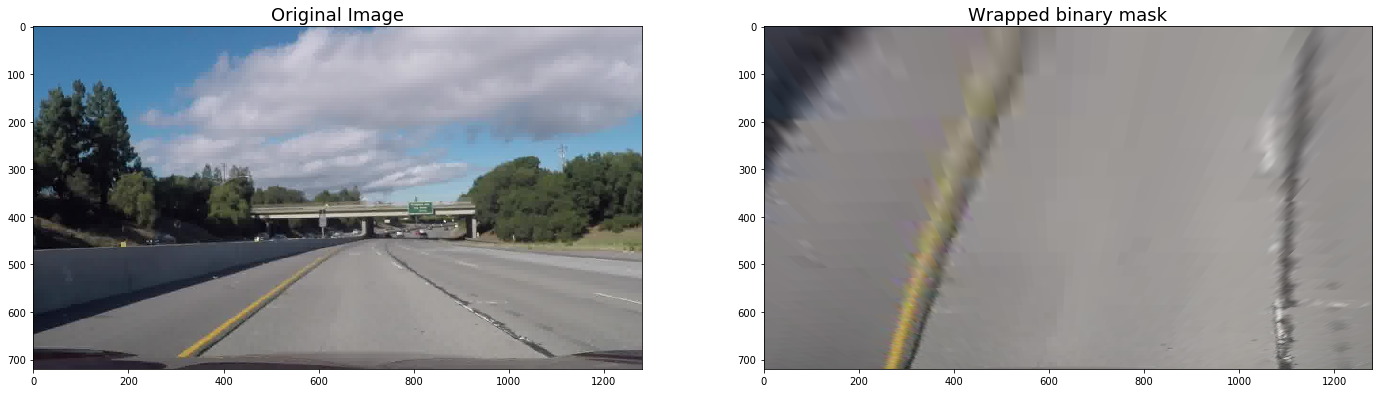

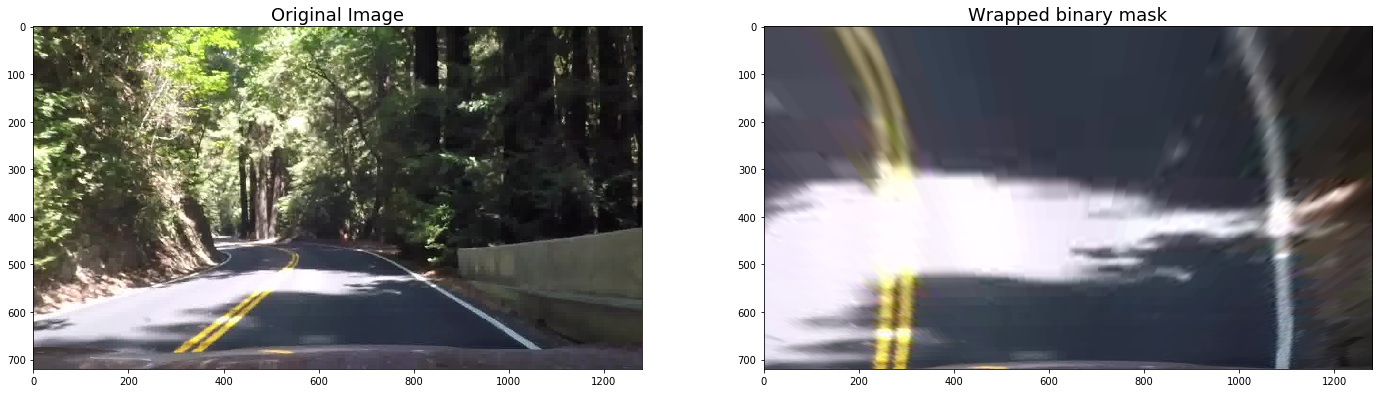

In [6]:
def binary2gray(binary):
    return np.dstack((binary, binary, binary)) * 255

def perspective_transforms(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return lambda image: cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR), \
           lambda image: cv2.warpPerspective(image, M_inv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

offset = 200
perspective_transform, perspective_inverse = perspective_transforms(
    np.float32([[315, 650], [554, 480], [736, 480], [1002,650]]),
    np.float32([[offset, 680], [offset, 0],  [1280 - offset, 0], [ 1280 - offset, 680]]))

## Show and save images with transformed masks
dirname = 'output_images/perspective'
if not os.path.exists(dirname): os.mkdir(dirname)

for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    result = perspective_transform(undistort(image))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(result)
    ax2.set_title('Wrapped binary mask', fontsize=18)
    
    save_to = os.path.join(dirname, 'img_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    save_to = os.path.join(dirname, 'mask_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

# Tresholding

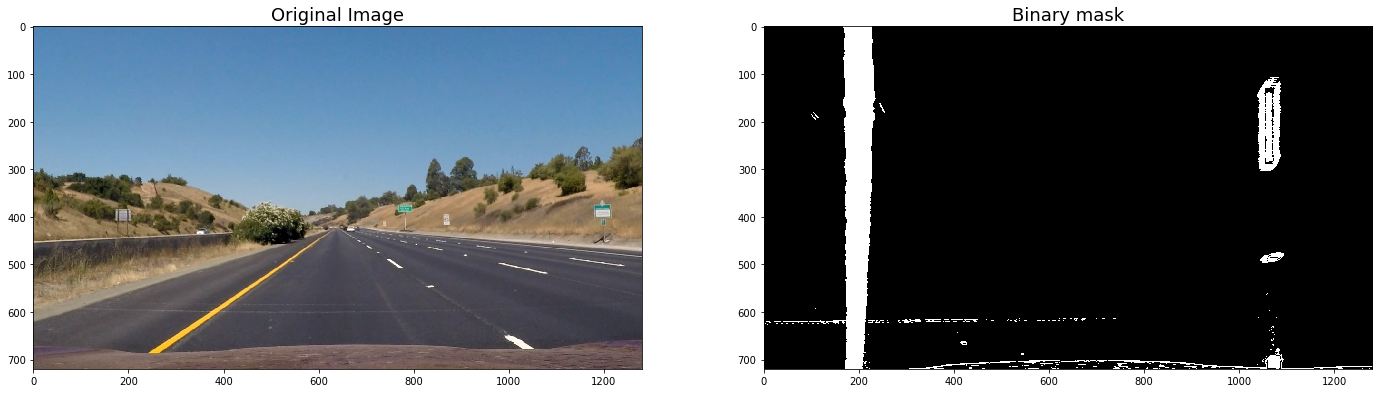

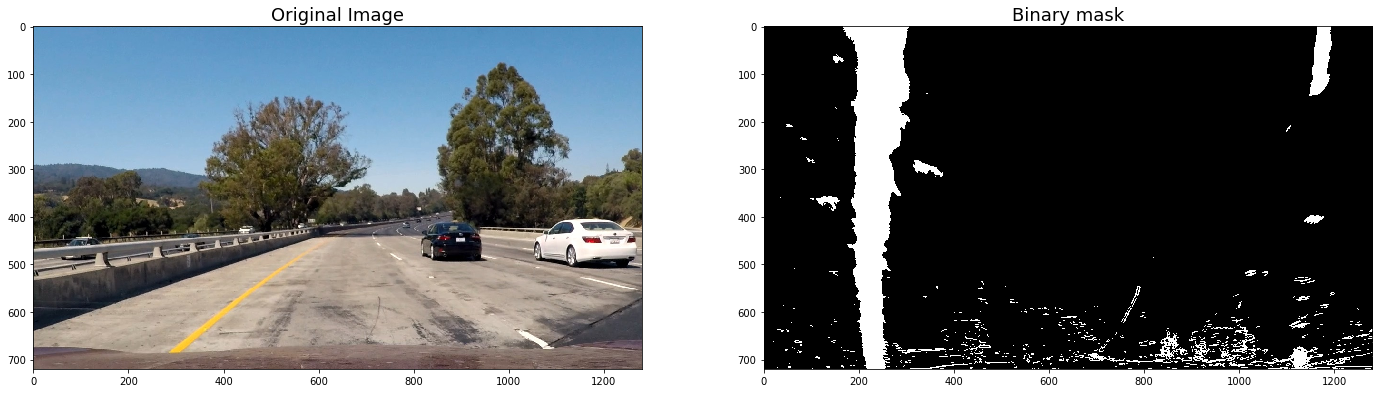

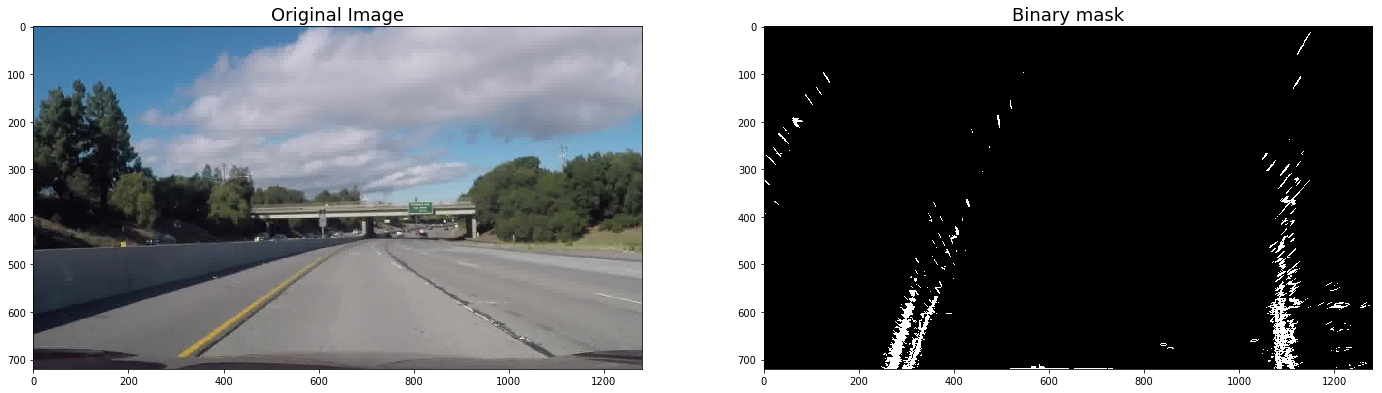

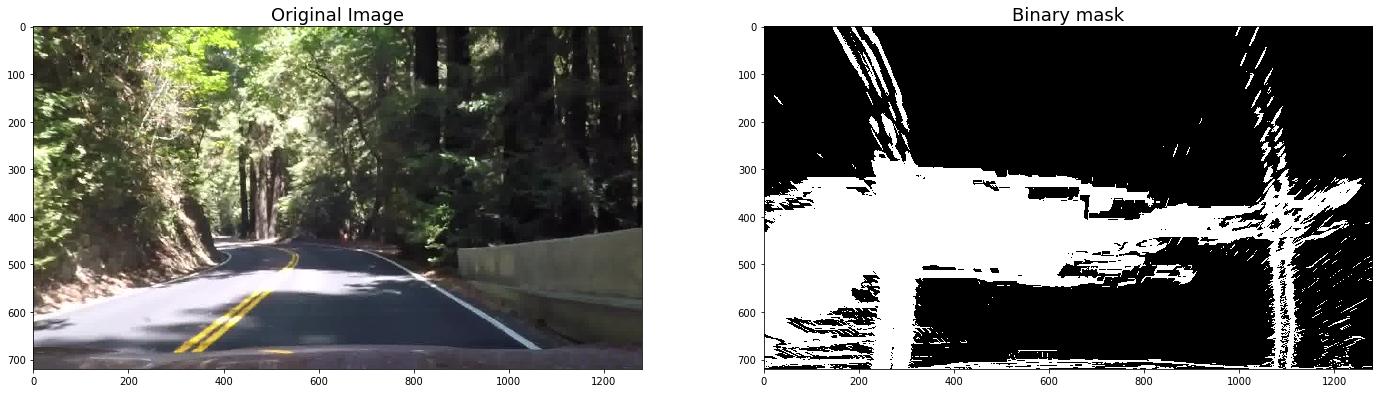

In [7]:

#### Tresholds function
def threshold_func(image, lum_thresh=(0, 255), sat_thresh=(0, 255), 
                  absx_thresh=(0, 255), absy_thresh=(0, 255), 
                  mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), 
                  sobel_kernel=3):
    ## Prefilter the input image
    value = image
    #value = cv2.GaussianBlur(image, (sobel_kernel, sobel_kernel), 0)

    ## Convert to HLS
    hls = cv2.cvtColor(value, cv2.COLOR_RGB2HLS)
    lum, sat = hls[:,:,1], hls[:,:,2]
    binary = np.zeros_like(lum)

    #yellow = cv2.inRange(hls, np.array([20,100,100]), np.array([30,255,255]))
    #white = cv2.inRange(hls, np.array([0,0,100]), np.array([255,255,255]))
    #value = cv2.bitwise_and(value,value, mask= white)

    ## Convert to gray and find x and y gradients
    gray = cv2.cvtColor(value, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    ## Take the absolute values of gradients
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    ## Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    mag = (gradmag/scale_factor).astype(np.uint8)
    
    ## Take the absolute value of the gradient direction,
    #dir = np.arctan2(absy, absx)

    binary[((lum >= lum_thresh[0]) & (lum <= lum_thresh[1]) 
           & (sat >= sat_thresh[0]) & (sat <= sat_thresh[1]))
           | ((absx >= absx_thresh[0]) & (absx <= absx_thresh[1]) 
           & (absy >= absy_thresh[0]) & (absy <= absy_thresh[1]) 
           & (mag >= mag_thresh[0]) & (mag <= mag_thresh[1]) )
           #& (dir >= dir_thresh[0]) & (dir <= dir_thresh[1]) 
          ] = 1
    
    return binary

## closure with  thresholds parameters
threshold = lambda image: threshold_func(image, 
                                         #absx_thresh=(10, 255), 
                                         sat_thresh=(80, 255), 
                                         lum_thresh=(40, 255),
                                         mag_thresh=(20, 255))

## Show and save images with masks
dirname = 'output_images/thresholds'
if not os.path.exists(dirname): os.mkdir(dirname)

for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    result = binary2gray(threshold(perspective_transform(undistort(image))))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(result)
    ax2.set_title('Binary mask', fontsize=18)
    
    save_to = os.path.join(dirname, 'img_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    save_to = os.path.join(dirname, 'mask_' + os.path.basename(name))
    cv2.imwrite(save_to, result)
    save_to = os.path.join(dirname, 'binary_' + os.path.basename(name))
    cv2.imwrite(save_to, binary2gray(threshold(undistort(image))))

# Finding lanes

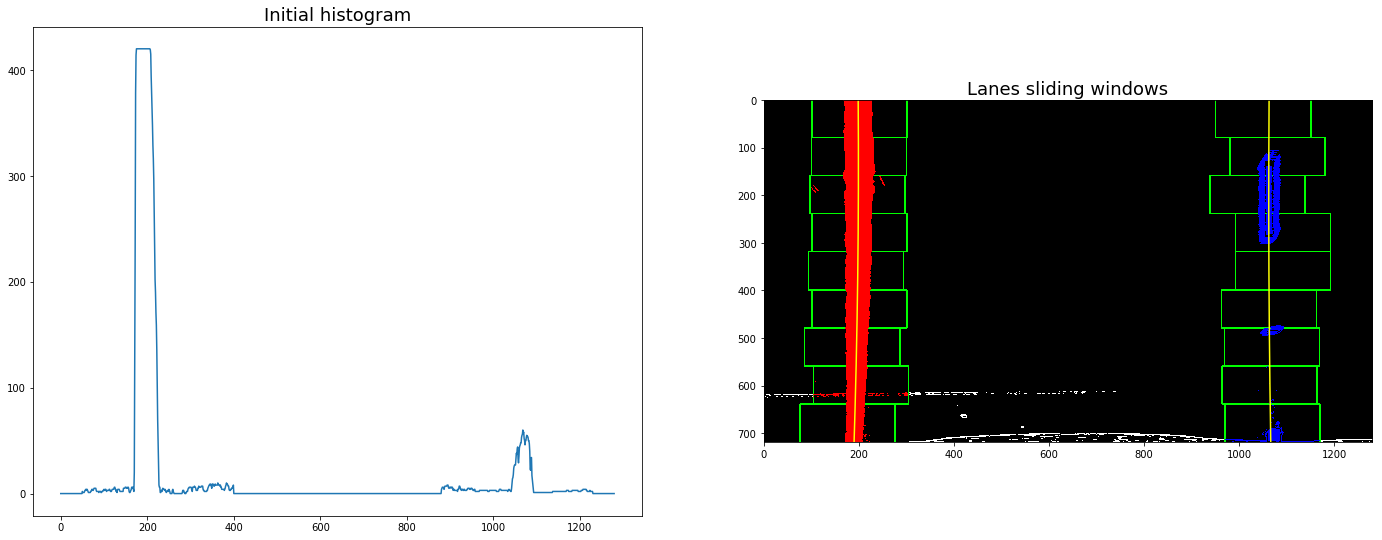

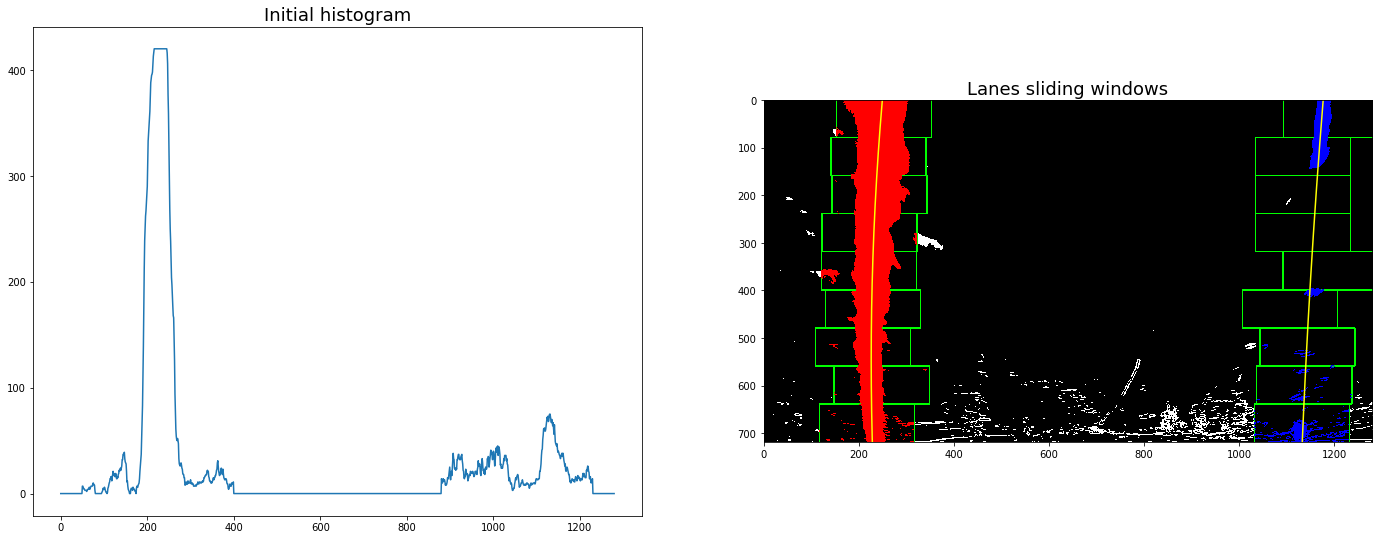

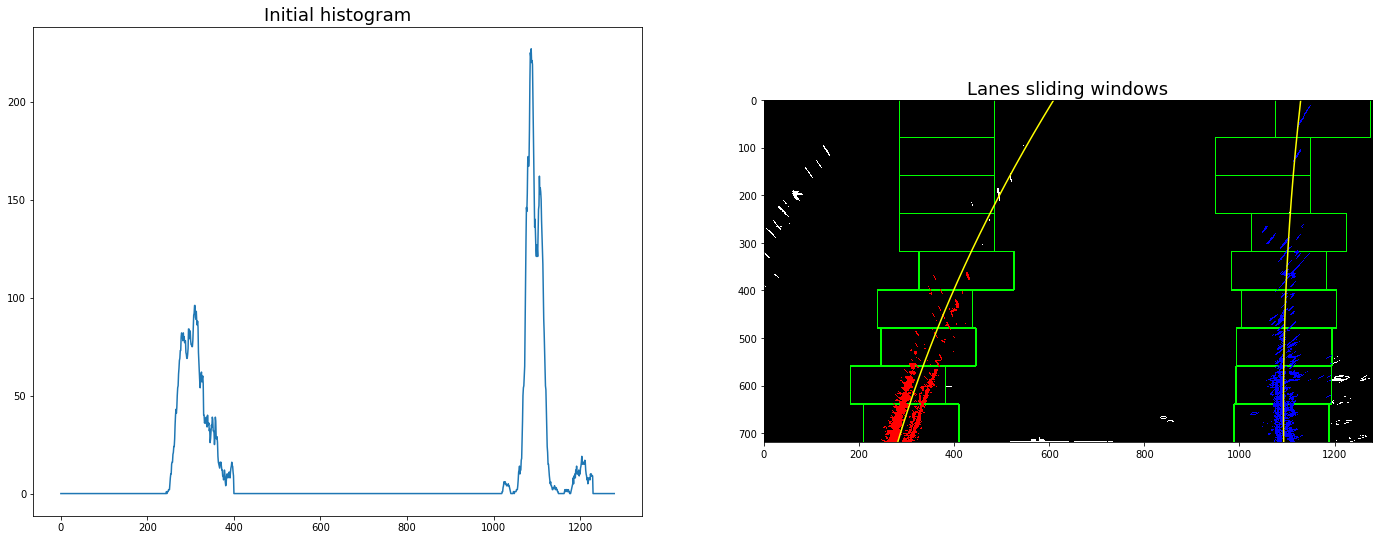

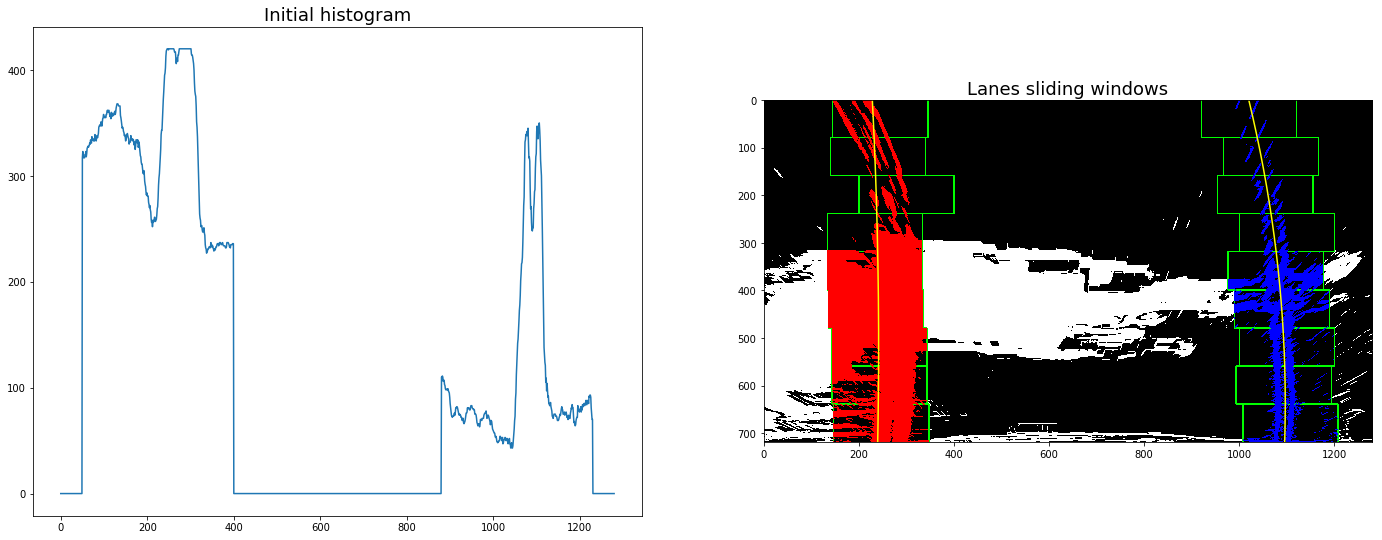

In [8]:

def find_lanes(binary_warped, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    image_height, image_width = binary_warped.shape
    left_histogram = np.sum(binary_warped[300:,0:int(image_width/2)], axis=0) # int(image_height/2)
    right_histogram = np.sum(binary_warped[300:,int(image_width/2):], axis=0) # int(image_height/2)
    left_histogram[:50] = 0
    left_histogram[-240:] = 0
    right_histogram[:240] = 0
    right_histogram[-50:] = 0
    # Create an output image to draw on and  visualize the result
    if plot:
        out_image = binary2gray(binary_warped)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(left_histogram)
    rightx_base = int(image_width/2) + np.argmax(right_histogram)
    histogram = np.hstack((left_histogram, right_histogram))
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image_height/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds, right_lane_inds = [], []
    left_windows_x, right_windows_x, windows_y = [], [], []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image_height - (window+1)*window_height
        win_y_high = image_height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        left_windows_x.append(leftx_current) 
        right_windows_x.append(rightx_current) 
        windows_y.append(image_height - (window+0.5)*window_height)
        # Draw the windows on the visualization image
        if plot:
            cv2.rectangle(out_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(leftx_current + 1.75 * (np.int(np.mean(nonzerox[good_left_inds])) - leftx_current))
            left_lane_inds.append(good_left_inds)
        if len(good_right_inds) > minpix:        
            rightx_current = int(rightx_current + 1.75 * (np.int(np.mean(nonzerox[good_right_inds])) - rightx_current))
            right_lane_inds.append(good_right_inds)

    # fit window centers
    left_fit_window = np.polyfit(windows_y, left_windows_x, 2)
    right_fit_window = np.polyfit(windows_y, right_windows_x, 2)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    # and fit a second order polynomial to each
    mix = 1
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    if len(left_lane_inds) >= 3:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit = mix * left_fit + (1.-mix)*left_fit_window
    else:
        left_fit = left_fit_window
        
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if len(right_lane_inds) >= 3:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit = mix * right_fit + (1.-mix)*right_fit_window
    else:
        right_fit = right_fit_window

    ## Color annotation of left/right lanes
    if plot:
        out_image[lefty, leftx] = [255, 0, 0]
        out_image[righty, rightx] = [0, 0, 255]
   
    return (left_fit, right_fit, out_image, histogram) if plot else (left_fit, right_fit)

def plot_fitted(ax, left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')

## Show and save images with transformed masks
dirname = 'output_images/lanes'
if not os.path.exists(dirname): os.mkdir(dirname)

for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    binary_warped = threshold(perspective_transform(undistort(image)))
    left_fit, right_fit, out_image, histogram = find_lanes(binary_warped, True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.plot(histogram)
    ax1.set_title('Initial histogram', fontsize=18)
    plot_fitted(ax2, left_fit, right_fit, np.linspace(0, out_image.shape[0]-1, out_image.shape[0]))
    ax2.imshow(out_image)
    ax2.set_title('Lanes sliding windows', fontsize=18)

    save_to = os.path.join(dirname, 'img_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    save_to = os.path.join(dirname, 'lanes_' + os.path.basename(name))
    cv2.imwrite(save_to, out_image)

Lanes refitting

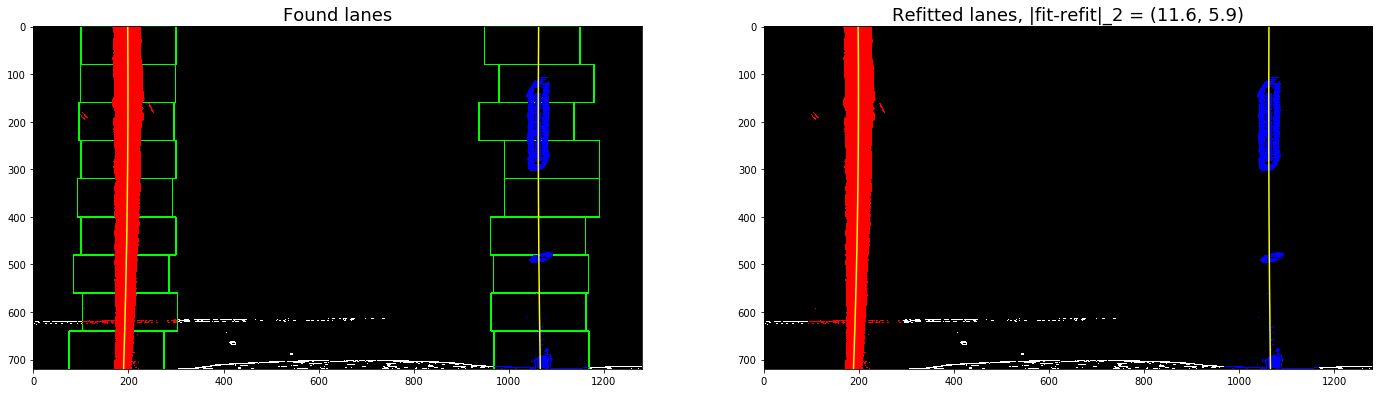

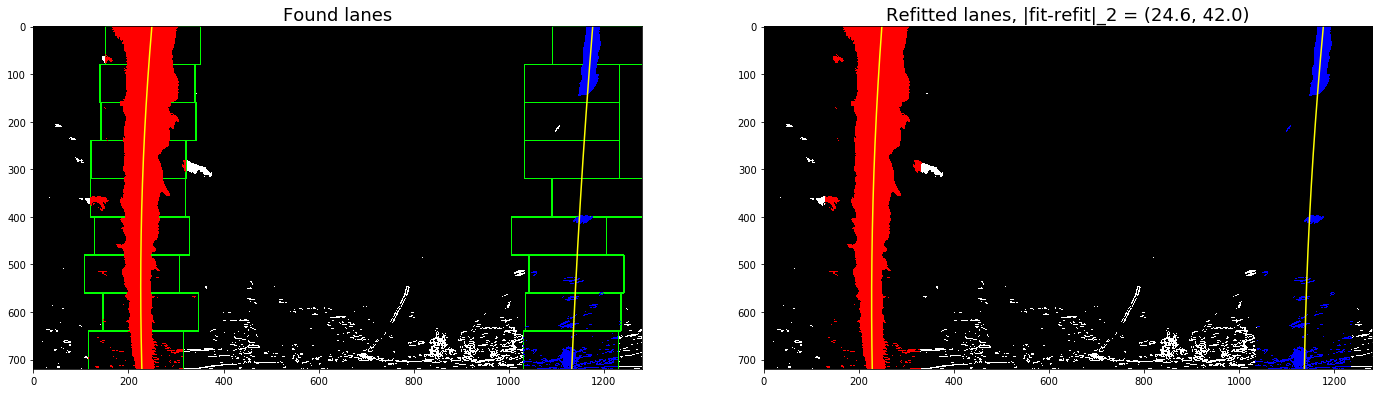

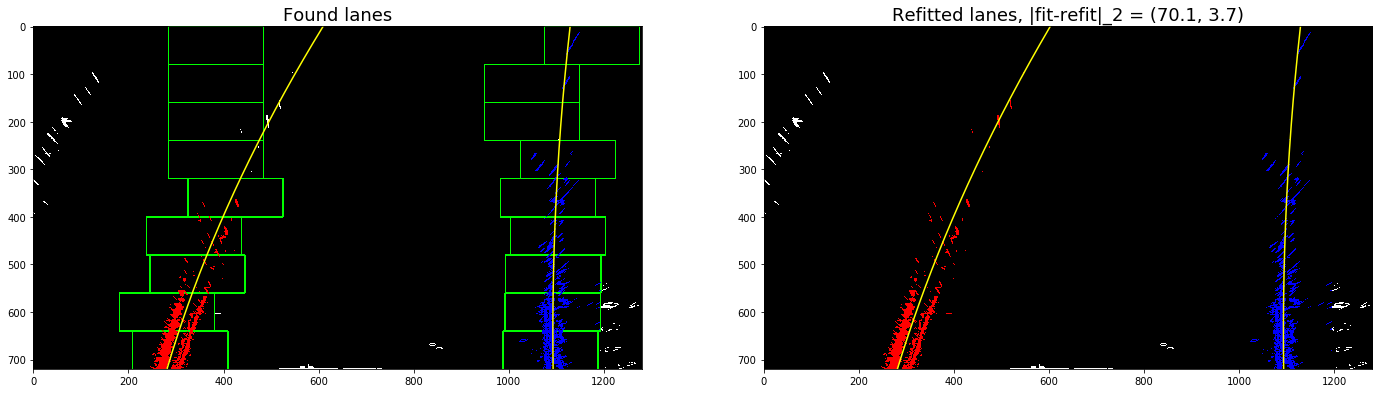

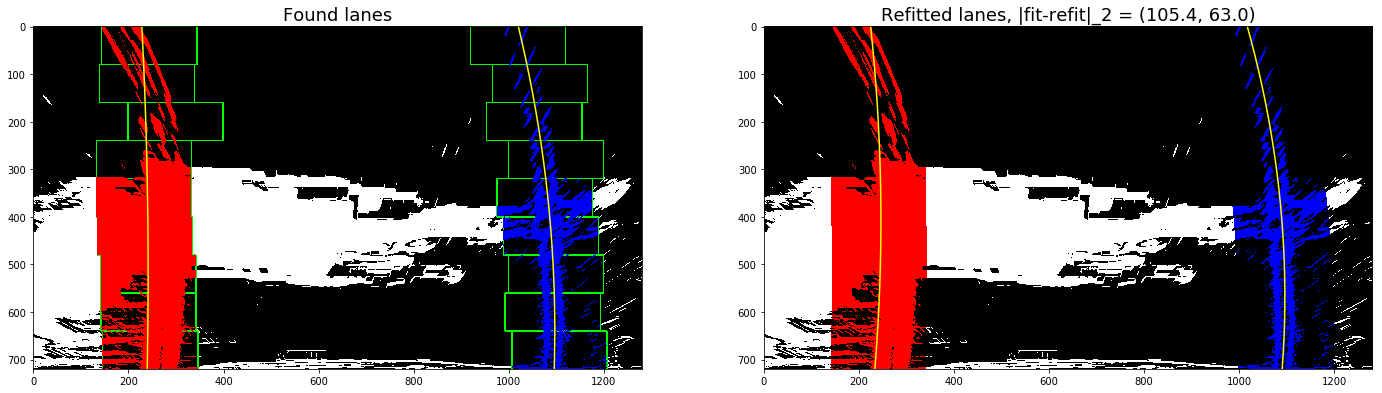

In [9]:
def refit_lanes(binary_warped, left_fit, right_fit, plot=False):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
        nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
            nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # and fit a second order polynomial to each
    if len(leftx) >= 3:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    
    if len(rightx) >= 3:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
       
    if plot:
        out_image = binary2gray(binary_warped)
        # Color in left and right line pixels
        out_image[lefty, leftx] = [255, 0, 0]
        out_image[righty, rightx] = [0, 0, 255]

    return (left_fit, right_fit, out_image) if plot else (left_fit, right_fit)

def norm2(f1, f2, h):
    ## Integrate[(a y^2+b y + c)^2, {y,0,h}]
    a, b, c = f1[0] - f2[0], f1[1] - f2[1], f1[2] - f2[2]
    return np.sqrt(c**2 * h + b * c * h**2 + (b**2 + 2 * a * c) * h**3 /3 + (a * b * h**4)/2 + (a**2 * h**5)/5)
    

## Show refitted lanes
for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    binary_warped = threshold(perspective_transform(undistort(image)))
    left_fit, right_fit, out_image1, _ = find_lanes(binary_warped, True)
    left_refit, right_refit, out_image2 = refit_lanes(binary_warped, left_fit, right_fit, True)
    
    height = out_image1.shape[0]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    plot_fitted(ax1, left_fit, right_fit, np.linspace(0, height-1, height))
    ax1.imshow(out_image1)
    ax1.set_title('Found lanes', fontsize=18)
    plot_fitted(ax2, left_refit, right_refit, np.linspace(0, height-1, height))
    ax2.imshow(out_image2)
    ax2.set_title('Refitted lanes, |fit-refit|_2 = ({:.1f}, {:.1f})'.format(norm2(left_fit, left_refit, height), norm2(right_fit, right_refit, height)), fontsize=18)

Plot fitted lane

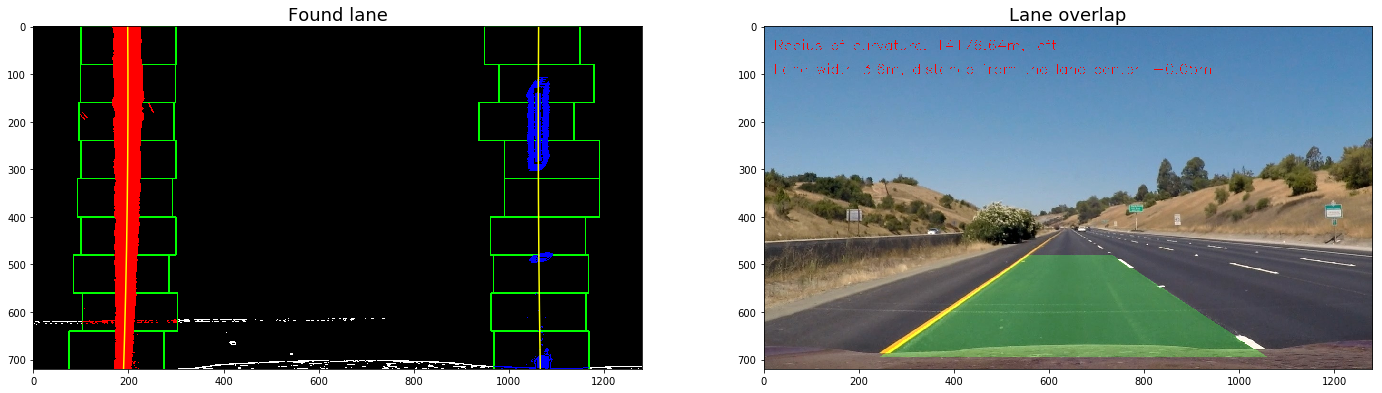

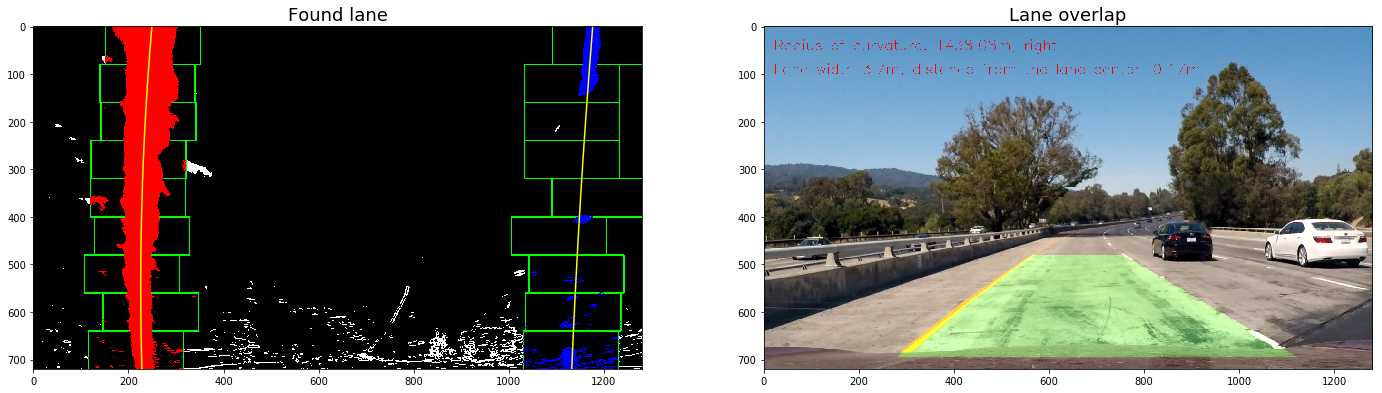

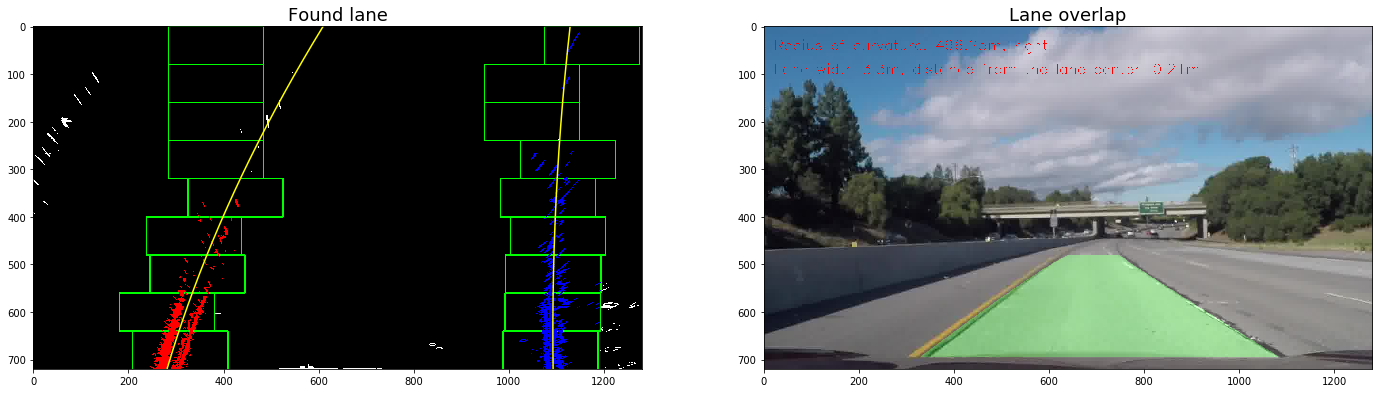

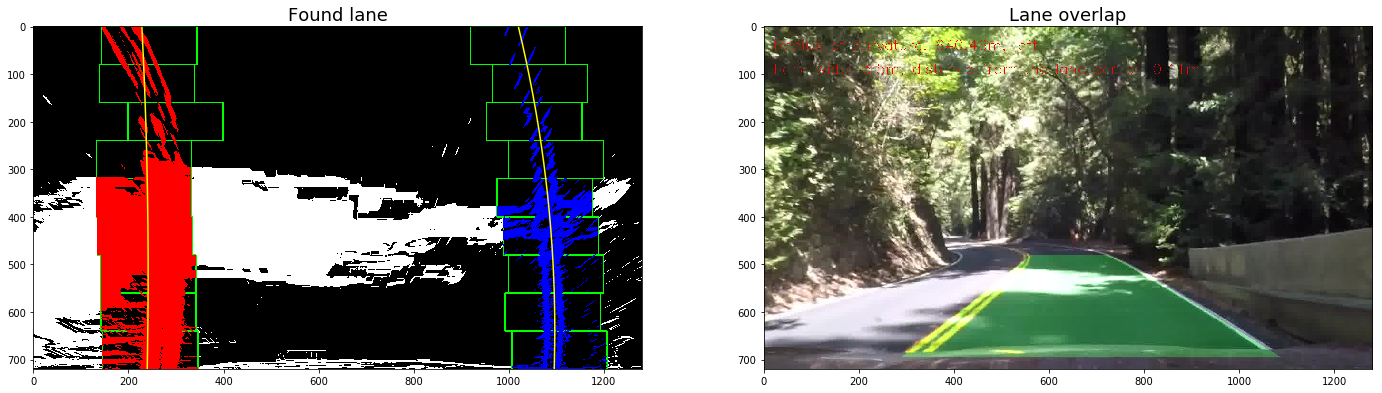

In [10]:
def plot_lane(image, binary_warped, perspective_inverse, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # and recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    lane = perspective_inverse(color_warp)

    # Combine the result with the original image
    return cv2.addWeighted(image, 1, lane, 0.25, 0)


## meters per pixels coefficients from wrapped straight_lines2.jpg image for the project video perspective transformation
kx, ky = 3.7 / (1280-380), 3. / 120

def get_signed_curavture(fit, Y):
    ## Use linear transform x = kx X, y = ky Y with (X,Y) pixel coordinates, (x,y) world coordinates
    ## fit is X = F(Y) = A Y^2 + B Y + C or after transform x/kx = A (y/ky)^2 + B y/ky + C
    ## so the curve is (A kx/ky^2 y + B kx/ky y + C, y) with derivatives
    ## x'= 2 A kx/ky^2 y + B kx/ky, x''= 2 A kx/ky^2, y'=1, y''=0
    ## the curvature is - 2 A kx/ky^2 / ((2 A kx/ky^2 y + B kx/ky)^2 + 1)^3/2
    ## or for Y is - 2 A kx/ky^2 / ((2 A kx/ky Y + B kx/ky)^2 + 1)^3/2
    A, B, C = fit
    return -2. * A * kx / ky**2 / (((2 * A * Y + B) * (kx/ky))**2. + 1.)**1.5
    
def get_lanes_positions(left_fit, right_fit, Y):
    left_pos = kx * (np.polyval(left_fit, Y) - 640)
    right_pos = kx * (np.polyval(right_fit, Y) - 640)
    return left_pos, right_pos


def plot_overwview(image, left_fit, right_fit):
    curvature_pos = image.shape[0]-20;
    left_curvature, right_curvature = get_signed_curavture(left_fit, curvature_pos), get_signed_curavture(right_fit, curvature_pos)
    avg_curvature = (left_curvature + right_curvature) / 2.
    left_pos, right_pos = get_lanes_positions(left_fit, right_fit, curvature_pos)
    
    text1 = 'Radius of curvature: {:.2f}m, {}'.format(np.abs(1./avg_curvature), 'left' if avg_curvature>=0 else 'right')
    text2 = 'Lane width {:.1f}m, distance from the lane center: {:.2f}m'.format(right_pos - left_pos, (right_pos + left_pos) / 2.)
    
    image = cv2.putText(image, text1, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    image = cv2.putText(image, text2, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)

    return image

## Show and save images with transformed masks
dirname = 'output_images/final'
if not os.path.exists(dirname): os.mkdir(dirname)

## Show refitted lanes
for name in test_images:
    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    binary_warped = threshold(perspective_transform(undistort(image)))
    left_fit, right_fit, wrapped_image, _ = find_lanes(binary_warped, True)
    out_image = plot_lane(image, binary_warped, perspective_inverse, left_fit, right_fit)
    out_image = plot_overwview(out_image, left_fit, right_fit)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    plot_fitted(ax1, left_fit, right_fit, np.linspace(0, height-1, height))
    ax1.imshow(wrapped_image)
    ax1.set_title('Found lane', fontsize=18)
    ax2.imshow(out_image)
    ax2.set_title('Lane overlap', fontsize=18)
    save_to = os.path.join(dirname, 'final_' + os.path.basename(name))
    cv2.imwrite(save_to, cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))

Video pipeline

In [11]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def make_video(pipeline, input_name, output_name, subclip=None, debug=False):
    left_fit, right_fit, frame, good_refits, bad_refits = None, None, 0, 0, 0
    
    def video_pipeline(image):
        nonlocal left_fit, right_fit, frame, good_refits, bad_refits, debug
        frame += 1
        binary = pipeline[0](image)
        if left_fit is None or right_fit is None:
            new_left_fit, new_right_fit, warp_image, _ = find_lanes(binary, True)
        else:
            new_left_fit, new_right_fit, warp_image = refit_lanes(binary, left_fit, right_fit, True)

            if new_left_fit is not None and new_right_fit is not None:
                ## check refit deviation from fit
                left_curvature = get_signed_curavture(new_left_fit, 720)
                right_curvature = get_signed_curavture(new_right_fit, 720)
                left_pos, right_pos = get_lanes_positions(new_left_fit, new_right_fit, 720)
                lane_width = right_pos - left_pos

                #print (norm2(left_fit, left_refit, 720), norm2(right_fit, right_refit, 720),
                #      np.abs(1./left_curvature), np.abs(1./right_curvature),
                #      lane_width)
                if (norm2(left_fit, left_refit, 720) > 20000. or norm2(right_fit, right_refit, 720) > 20000.
                   or np.abs(1./left_curvature) < 150 or np.abs(1./right_curvature) < 150 
                   or lane_width < 2.5 and lane_width > 4.5):
                    new_left_fit, new_right_fit, warp_image, _ = find_lanes(binary, True)
                    bad_refits += 1
                else:
                    good_refits += 1

            # keep old data if failed to find
            new_left_fit = left_fit if new_left_fit is None else new_left_fit
            new_right_fit = right_fit if new_right_fit is None else new_right_fit

        alpha = 0.2
        left_fit = alpha * new_left_fit + (1-alpha) * left_fit if left_fit is not None else new_left_fit
        right_fit = alpha * new_right_fit + (1-alpha) * right_fit if right_fit is not None else new_right_fit
        
        out_image = plot_lane(image, binary_warped, perspective_inverse, left_fit, right_fit)
        out_image = plot_overwview(out_image, left_fit, right_fit)
    
        # place debug info
        if debug:
            warp_pos, warp_image = (30, 1060), cv2.resize(warp_image, (200, 140), interpolation = cv2.INTER_CUBIC)
            out_image[warp_pos[0]:warp_pos[0]+warp_image.shape[0], warp_pos[1]:warp_pos[1]+warp_image.shape[1], :] = warp_image
            out_image = cv2.putText(out_image, 'frame {:04d}, good refits  {:4d}, bad refits {:4d}'.format(frame, good_refits, bad_refits), 
                                (880, 15), cv2.FONT_HERSHEY_SIMPLEX, .5, 255)

        return out_image
    
    clip2 = VideoFileClip(input_name, verbose=False);
    if subclip is not None:
        clip2 = clip2.subclip(*subclip)
    clip = clip2.fl_image(video_pipeline);
    %time clip.write_videofile(output_name, audio=False, verbose=False);
    return HTML("""
<video width="960" height="540" controls>
  <source src="{}?{}">
</video>
""".format(output_name, time.time()))

In [12]:
offset = 200
perspective_transform, perspective_inverse = perspective_transforms(
    np.float32([[315, 650], [554, 480], [736, 480], [1002,650]]),
    np.float32([[offset, 680], [offset, 0],  [1280 - offset, 0], [ 1280 - offset, 680]]))
pipeline = (lambda image: threshold(perspective_transform(undistort(image))), perspective_inverse)  

make_video(pipeline, 'project_video.mp4', 'output_video/project_video.mp4', debug=True, subclip=None)

100%|█████████▉| 1260/1261 [02:20<00:00, 10.10it/s]


CPU times: user 2min 45s, sys: 11.9 s, total: 2min 57s
Wall time: 2min 22s


# Challenges

In the first challange camera has a different perpective transform

In [13]:
offset = 150
perspective_transform, perspective_inverse = perspective_transforms(
    np.float32([[380, 650], [598, 480], [724, 480], [1010,650]]),
    np.float32([[offset, 680], [offset, 0],  [1280 - offset, 0], [ 1280 - offset, 680]]))
pipeline = (lambda image: threshold(perspective_transform(undistort(image))), perspective_inverse) 

make_video(pipeline, 'challenge_video.mp4', 'output_video/challenge_video.mp4', debug=True)

100%|██████████| 485/485 [00:55<00:00,  9.18it/s]


CPU times: user 1min 4s, sys: 4.82 s, total: 1min 9s
Wall time: 56.6 s


In [14]:
offset = 200
perspective_transform, perspective_inverse = perspective_transforms(
    np.float32([[315, 650], [554, 480], [736, 480], [1002,650]]),
    np.float32([[offset, 680], [offset, 0],  [1280 - offset, 0], [ 1280 - offset, 680]]))

pipeline = (lambda image: perspective_transform(threshold(undistort(image))), perspective_inverse)

make_video(pipeline, 'harder_challenge_video.mp4', 'output_video/harder_challenge_video.mp4', debug=True)

100%|█████████▉| 1199/1200 [02:49<00:00,  6.07it/s]


CPU times: user 3min 12s, sys: 11.7 s, total: 3min 24s
Wall time: 2min 51s
